# Ques 1: SPAM HAM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter
from gensim.models import Word2Vec,KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk import word_tokenize 
from nltk.stem import WordNetLemmatizer
import nbformat
import random
import plotly.express as px
from sklearn.decomposition import PCA
import contractions
nltk.download('punkt_tab', quiet=True) #NLTK < 3.9 uses punkt
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True) 
random.seed(42)

In [2]:
import gensim.downloader as api
model = api.load("word2vec-google-news-300")

Data preprocessing

In [3]:
df = pd.read_csv(r'C:\1 All about placements\LS\spam.csv', encoding='latin1') 
df.drop(columns=['Unnamed: 2', 'Unnamed: 3' , 'Unnamed: 4'], axis=1, inplace=True)
df.rename(columns={'v1': 'label' , 'v2': 'text'}, inplace=True)
df=df[['text', 'label']]
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [4]:
#stopw word + to lower + tokenize

df['tokens'] = df['text'].apply(lambda s: word_tokenize(s))

df['tokens'] = df['tokens'].apply(lambda ts: [t.lower() for t in ts])

stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(
    lambda ts: [t for t in ts if t not in stop_words]
)

sentences = df['tokens'].tolist() #not used in this program, useful for own w2v prep.
df.head()

,text,label,tokens
0,"Go until jurong point, crazy.. Available only ...",ham,"[go, jurong, point, ,, crazy, .., available, b..."
1,Ok lar... Joking wif u oni...,ham,"[ok, lar, ..., joking, wif, u, oni, ...]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,U dun say so early hor... U c already then say...,ham,"[u, dun, say, early, hor, ..., u, c, already, ..."
4,"Nah I don't think he goes to usf, he lives aro...",ham,"[nah, n't, think, goes, usf, ,, lives, around,..."


In [5]:
#IGNORE !!!

# model = Word2Vec(
#     sentences, 
#     vector_size=200,   
#     window=5,        
#     min_count=1,    
#     workers=4,
#     seed=42    
# )

# pca = PCA(n_components=3)
# X = pca.fit_transform(model.wv.get_normed_vectors())

# labels = model.wv.index_to_key           
# fig = px.scatter_3d(
#     x=X[200:300, 0],
#     y=X[200:300, 1],
#     z=X[200:300, 2],
#     color=labels[200:300],
#     hover_name=labels[200:300]   
# )
# fig.show()

Transforming w2v google news on preprocessed data

In [6]:
# Flatten all tokens into a single list
all_tokens = [word for message in df['tokens'] for word in message]

# Count word frequencies
token_counts = Counter(all_tokens)

# Get Word2Vec vocab
vocab = set(model.key_to_index)

# In-vocab and out-of-vocab token counts
in_vocab = {word: count for word, count in token_counts.items() if word in vocab}
oov = {word: count for word, count in token_counts.items() if word not in vocab}

# Function to convert a message to a 300-dim vector
def message_to_vector(tokens, model):
    vectors = [model[word] for word in tokens if word in model.key_to_index]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Apply the function to all rows
df['vector'] = df['tokens'].apply(lambda tokens: message_to_vector(tokens, model))
df.head()

,text,label,tokens,vector
0,"Go until jurong point, crazy.. Available only ...",ham,"[go, jurong, point, ,, crazy, .., available, b...","[-0.019805908, 0.05167062, 0.02709961, 0.21868..."
1,Ok lar... Joking wif u oni...,ham,"[ok, lar, ..., joking, wif, u, oni, ...]","[-0.06323496, 0.0803833, 0.060943604, 0.102498..."
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,"[free, entry, 2, wkly, comp, win, fa, cup, fin...","[-0.03482437, -0.00703014, -0.06348601, 0.1161..."
3,U dun say so early hor... U c already then say...,ham,"[u, dun, say, early, hor, ..., u, c, already, ...","[-0.06568061, 0.0262146, 0.1081543, 0.0869751,..."
4,"Nah I don't think he goes to usf, he lives aro...",ham,"[nah, n't, think, goes, usf, ,, lives, around,...","[0.01461792, 0.07184219, -0.005203247, 0.14686..."


Training and plotting accuracy

In [7]:
X = np.vstack(df['vector'].values)  
y = df['label'].map({'ham': 0, 'spam': 1}).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Test Accuracy: 0.947085201793722


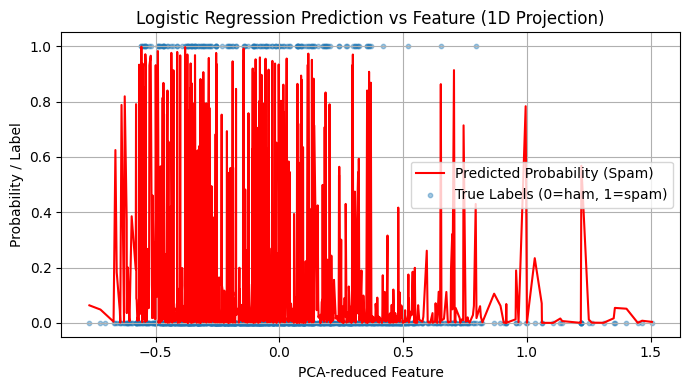

In [8]:
# in 1D for viz.
pca = PCA(n_components=1)
X1D = pca.fit_transform(X_test)

# Get predicted probabilities
y_prob = clf.predict_proba(X_test)[:, 1]

# Sort for smooth line plot
sorted_idx = np.argsort(X1D.flatten())
X1D_sorted = X1D.flatten()[sorted_idx]
y_prob_sorted = y_prob[sorted_idx]

# Plot
plt.figure(figsize=(7, 4))
plt.plot(X1D_sorted, y_prob_sorted, label="Predicted Probability (Spam)", color="red")
plt.scatter(X1D, y_test, alpha=0.4, label="True Labels (0=ham, 1=spam)", s=10)
plt.xlabel("PCA-reduced Feature")
plt.ylabel("Probability / Label")
plt.title("Logistic Regression Prediction vs Feature (1D Projection)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

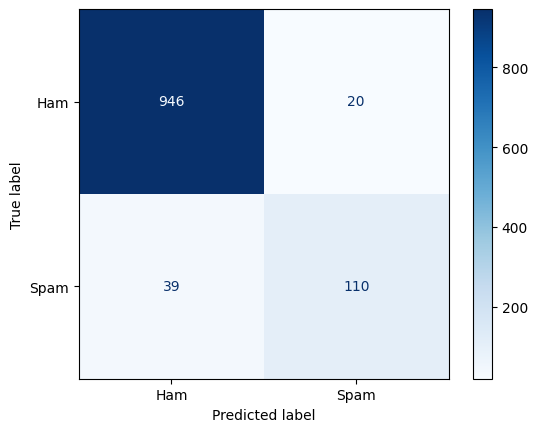

In [9]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues')

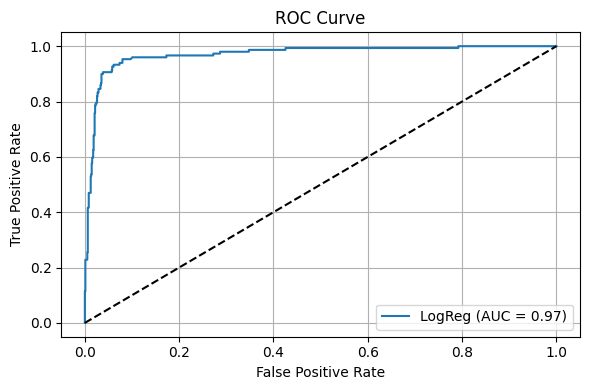

In [10]:
# Predict probabilities
y_proba = clf.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

predict_message_class > for preprocessing unkown text and it's prediction( following pipeline of model)

In [11]:
def predict_message_class(model, w2v_model, message):
    # Preprocess
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(message.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    # Get vectors
    vectors = [w2v_model[word] for word in tokens if word in w2v_model.key_to_index]
    
    if not vectors:
        message_vec = np.zeros(w2v_model.vector_size).reshape(1, -1)
    else:
        message_vec = np.mean(vectors, axis=0).reshape(1, -1)

    # Predict
    pred = model.predict(message_vec)[0]
    return "spam" if pred == 1 else "ham"

In [12]:
# unkown text and prediction
message = ["Congratulations! In lucky draw, you won a Iphone, claim now.",
            "Hey, just checking if we’re still on for the project meeting tomorrow at 10 AM. Let me know if the timing works for you."]

for i in message:
    print(f'message: {i}, \nOutput: {predict_message_class(clf, model, i)}')
    


message: Congratulations! In lucky draw, you won a Iphone, claim now., 
Output: spam
message: Hey, just checking if we’re still on for the project meeting tomorrow at 10 AM. Let me know if the timing works for you., 
Output: ham


# Ques 2

Data preprocessing


In [13]:
df = pd.read_csv(r'C:\1 All about placements\LS\Tweets.csv')
df = df[['text', 'airline_sentiment']]

text data Preprocessing

In [14]:
# Expand contractions
df['text'] = df['text'].apply(contractions.fix)
df['text'] = df['text'].str.replace(r"http\S+|www\S+|https\S+", '', regex=True)  # url links
df['text'] = df['text'].str.replace(r"@\w+", '', regex=True)                     # @mentions
df['text'] = df['text'].str.replace(r"#", '', regex=True)                        # Hashtag symbol
df['text'] = df['text'].str.replace(r"[^\w\s]", '', regex=True)                  # remove all unnecessary special symbols(including # and puntuation) keep text
df['text'] = df['text'].str.lower()                                              # to lower
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))         # emoji

# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized)

df['text'] = df['text'].apply(lemmatize_text)
df.head()

,text,airline_sentiment
0,what said,neutral
1,plus you have added commercial to the experien...,positive
2,i did not today must mean i need to take anoth...,neutral
3,it is really aggressive to blast obnoxious ent...,negative
4,and it is a really big bad thing about it,negative


In [15]:
# Flatten all tokens into a single list
all_tokens = [word for message in df['text'] for word in message]

# Count word frequencies
token_counts = Counter(all_tokens)

# Get Word2Vec vocab
vocab = set(model.key_to_index)

# In-vocab and out-of-vocab token counts
in_vocab = {word: count for word, count in token_counts.items() if word in vocab}
oov = {word: count for word, count in token_counts.items() if word not in vocab}

# Function to convert a message to a 300-dim vector
def message_to_vector(tokens, model):
    vectors = [model[word] for word in tokens if word in model.key_to_index]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Apply the function to all rows
df['vector'] = df['text'].apply(lambda tokens: message_to_vector(tokens, model))
df.head()

,text,airline_sentiment,vector
0,what said,neutral,"[-0.24430339, 0.16129558, -0.06933594, 0.14921..."
1,plus you have added commercial to the experien...,positive,"[-0.14963059, 0.123883925, 0.0053042457, 0.137..."
2,i did not today must mean i need to take anoth...,neutral,"[-0.17268452, 0.12004009, -0.034398127, 0.1593..."
3,it is really aggressive to blast obnoxious ent...,negative,"[-0.18593913, 0.11602709, -0.0058980803, 0.127..."
4,and it is a really big bad thing about it,negative,"[-0.20785862, 0.101919666, 0.0049596718, 0.145..."


Model training

In [16]:
X = np.vstack(df['vector'].values)  
y = df['airline_sentiment'].map({'positive': 2, 'neutral': 1, 'negative': 0}).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = LogisticRegression(
    multi_class='multinomial', 
    solver='newton-cg', 
    max_iter=10000
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

c:\1 All about placements\LS\venv310\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy: 0.6533469945355191


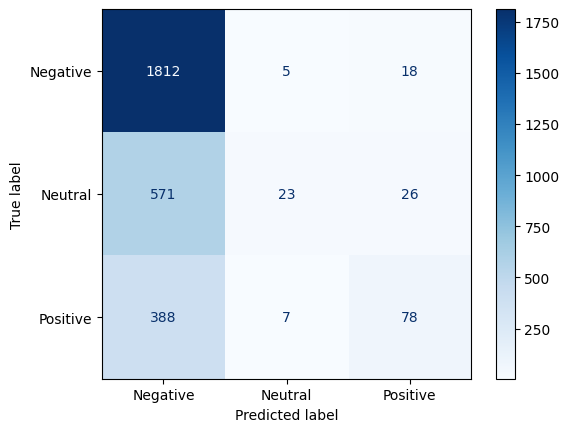

In [17]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')

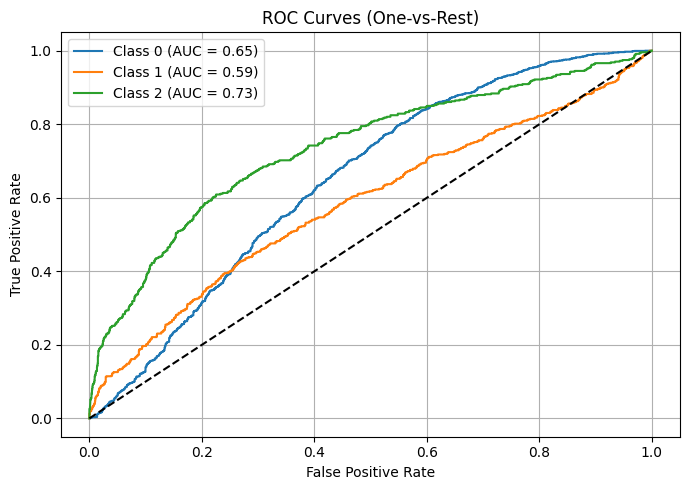

In [18]:
# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]
y_score = clf.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(7, 5))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

prediction function using preprocessing pipleine and model training

In [19]:
def preprocess_tweet(tweet):

    lemmatizer = WordNetLemmatizer()
    tweet = contractions.fix(tweet)

    # Remove URLs, mentions, hashtags, punctuation, emojis
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet)
    tweet = re.sub(r"@\w+", '', tweet)
    tweet = re.sub(r"#", '', tweet)
    tweet = re.sub(r"[^\w\s]", '', tweet)
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)

    # Lowercase
    tweet = tweet.lower()

    # Tokenize, remove stopwords, lemmatize
    tokens = word_tokenize(tweet)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens


In [20]:
def predict_tweet_sentiment(model, w2v_model, tweet):
    tokens = preprocess_tweet(tweet)
    
    # Average Word2Vec vector
    vectors = [w2v_model[word] for word in tokens if word in w2v_model]
    
    if len(vectors) == 0:
        return "unknown"  # or neutral as fallback

    avg_vector = np.mean(vectors, axis=0).reshape(1, -1)

    pred = model.predict(avg_vector)[0]
    label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    return label_map[pred]


In [21]:
message = ["@UnitedAirlines lost my baggage again... unbelievable service 😡 #neveragain #airlinemess",
            "Huge shoutout to @Delta for the smooth flight but irritating staff! ✈️ #ThankYou #FlyDelta",
            "Boarding started on time at gate 24. Flight to NYC with @AmericanAir #TravelUpdate"]

for i in message:
    print(f'message: {i}, \nOutput: {predict_tweet_sentiment(clf, model, i)}')

message: @UnitedAirlines lost my baggage again... unbelievable service 😡 #neveragain #airlinemess, 
Output: neutral
message: Huge shoutout to @Delta for the smooth flight but irritating staff! ✈️ #ThankYou #FlyDelta, 
Output: negative
message: Boarding started on time at gate 24. Flight to NYC with @AmericanAir #TravelUpdate, 
Output: neutral
